# Variational Inference Performance Experiments
This notebook executes performance benchmarks on the BayesVI.jl code. Figures are plotted ands saved for the report. The following experiments are done here:
- Increasing number of MC samples vs training time
- Increasing epochs vs training time
- Increasing nodes in hidden layers vs training time
- Increasing depth of neural network vs training time
- Increasing number of MC samples vs ELBO gradient approximation

! NOTE ! this notebook can take up to 25 minutes to completely execute

In [1]:
begin
    using Plots
    using Distributions
    using Random
    include("./BayesVI.jl")
    using .BayesVI
    include("./Datasets.jl")
    using .Datasets
end

┌ Info: OMEinsum loaded the CUDA module successfully
└ @ OMEinsum C:\Users\andre\.julia\packages\OMEinsum\0C2IK\src\cueinsum.jl:117


### Experiment: increasing MC samples vs training time.

In [2]:
mc_sample_list = 50
times = zeros(mc_sample_list)
for mc_samples in range(1, mc_sample_list)
    num_weights, predictions, logprob, ensemble_prediction = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
    inputs, targets = build_dataset_1()
    log_posterior(weights) = logprob(weights, inputs, targets)
    objective, unpack_params = black_box_variational_inference(log_posterior, num_weights, mc_samples)
    e = @elapsed train_bayesian_neural_network(200, 0.1, num_weights, objective);
    times[mc_samples] = e
end

In [4]:
# Plot results.
mcvtime = plot(LinRange(1,mc_sample_list,mc_sample_list), times, title="MC Samples vs Training Time (s)", label="", xlabel="MC Samples", ylabel="Train Time (s)")
savefig(mcvtime, "images/mcvtime.png")
current()

### Experiment: increasing epochs vs training time.

In [5]:
trials = 100
repeats = 10
times = zeros(trials, repeats)
for rep in range(1, repeats)
    for epochs in range(1, trials)
        num_weights, predictions, logprob, ensemble_prediction = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
        inputs, targets = build_dataset_1()
        log_posterior(weights) = logprob(weights, inputs, targets)
        objective, unpack_params = black_box_variational_inference(log_posterior, num_weights, 1)
        e = @elapsed train_bayesian_neural_network(epochs, 0.1, num_weights, objective);
        times[epochs, rep] = e
    end
end

In [6]:
# Plot results.
averaged_times = mean(times, dims=2);
epochs_vs_avg_time = plot(LinRange(1,trials,trials), averaged_times, title="Epochs vs Training Time (s)", label="", xlabel="Number of Epochs", ylabel="Train Time (s)")
savefig(epochs_vs_avg_time, "images/epochs_vs_avg_time.png")
current()

### Experiment: increasing number of nodes in hidden layers vs training time.

In [9]:
trials = 30
repeats = 10
times = zeros(trials, repeats)
for i in range(1, repeats)
    for val in range(1, trials)
        num_weights, predictions, logprob, ensemble_prediction = make_neural_network_functions([1, val, val, 1], 0.1, 0.01, rbf)
        inputs, targets = build_dataset_1()
        log_posterior(weights) = logprob(weights, inputs, targets)
        objective, unpack_params = black_box_variational_inference(log_posterior, num_weights, 1)
        e = @elapsed train_bayesian_neural_network(200, 0.1, num_weights, objective);
        times[val, i] = e
    end
end

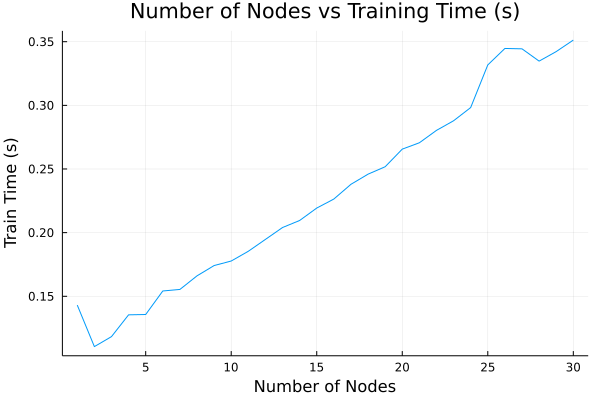

In [11]:
# Plot results.
averaged_times = mean(times, dims=2);
num_nodes_vs_train_time = plot(LinRange(1,trials,trials), averaged_times, title="Number of Nodes vs Training Time (s)", label="", xlabel="Number of Nodes", ylabel="Train Time (s)")
savefig(num_nodes_vs_train_time, "images/num_nodes_vs_train_time.png")
current()

### Experiment: increasing depth of neural network vs training time.

In [13]:
depth = 50
repeats = 10
times = zeros(depth, repeats)
for i in range(1, repeats)
    for val in range(1, depth)
        architecture = convert(Array{Int64}, vcat(1, ones(val) .* 20, 1))
        num_weights, predictions, logprob, ensemble_prediction = make_neural_network_functions(architecture, 0.1, 0.01, rbf)
        inputs, targets = build_dataset_1()
        log_posterior(weights) = logprob(weights, inputs, targets)
        objective, unpack_params = black_box_variational_inference(log_posterior, num_weights, 1)
        e = @elapsed train_bayesian_neural_network(200, 0.1, num_weights, objective);
        times[val, i] = e
    end
end

In [14]:
# Plot results.
averaged_times = mean(times, dims=2);
architecture_vs_train_time = plot(LinRange(1,depth,depth), averaged_times, title="Network Depth vs Training Time (s)", label="", xlabel="Depth of Neural Network", ylabel="Train Time (s)")
savefig(architecture_vs_train_time, "images/architecture_vs_train_time.png")
current()

### Experiment: increasing MC samples vs ELBO

In [17]:
Random.seed!(100)
mc_samples = [1,10,20,30,40]
times = zeros(depth, repeats)
elbos_list = Array{}[]
for mc_sample in mc_samples
    num_weights, predictions, logprob, ensemble_prediction = make_neural_network_functions([1, 20, 20, 1], 0.1, 0.01, rbf)
    inputs, targets = build_dataset_1()
    log_posterior(weights) = logprob(weights, inputs, targets)
    objective, unpack_params = black_box_variational_inference(log_posterior, num_weights, mc_sample)
    _, elbos = train_bayesian_neural_network(200, 0.1, num_weights, objective)
    push!(elbos_list, elbos)
end

In [18]:
# Plot results
for i in range(1,5)
    mc_sample = mc_samples[i]
    mc_vs_elbo = plot(elbos_list[i], title="Epoch vs ELBO ($mc_sample MC Sample)", xlabel="Epochs", ylabel="ELBO", label="")
    savefig(mc_vs_elbo, "images/mc_vs_elbo_$mc_sample.png")
end